# **Import Libraries**

In [2]:
from __future__ import print_function

import sklearn
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import IPython
import matplotlib
import os
import cv2

from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from matplotlib import pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

---
# **LDA Class**

- Class Classifier

In [3]:
class Classifier:
    def predict(self, X):
        raise NotImplementedError("Predict method must be implemented in subclasses.")

    def score(self, X, y):
        raise NotImplementedError("Score method must be implemented in subclasses.")

- Class LDA

In [4]:
class LDA(Classifier):
    def __init__(self):
        self.class_means = None
        self.covariance_matrix = None

    def train(self, x_train, y_train):
        # class means
        self.class_means = np.array([np.mean(x_train[y_train == c], axis=0) for c in np.unique(y_train)])

        # covariance matrix
        self.covariance_matrix = np.cov(x_train, rowvar=False)

    def predict(self, x_test):
        if self.class_means is None or self.covariance_matrix is None:
            raise RuntimeError("The model hasn't been trained.")

        # discriminant function for each class
        discriminant_values = np.array(
            [np.sum(np.dot((x_test - mean), pinv(self.covariance_matrix)) * (x_test - mean), axis=1) for mean in self.class_means])

        # Predict the class with the minimum discriminant value
        predictions = np.argmin(discriminant_values, axis=0)

        return predictions

    def score(self, x_test, y_test):
        predictions = self.predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        return accuracy

---

# **Face Images**

## eigenface & PCA




### `Eigenface: A Machine Learning Technique for Dimensionality Reduction`

**Eigenface** is a machine learning technique used for **dimensionality reduction** and has applications in areas such as **face recognition**, **speech recognition**, and **image processing**. It is based on **Principal Component Analysis (PCA)**, which is a statistical method for reducing the number of variables (dimensions) in data while retaining the most important information.

In face recognition, the Eigenface method is applied to reduce the dimensionality of facial image data. This dimensionality reduction allows for **faster and more efficient recognition**.

In PCA, the data is represented as an `N × M` data matrix, where `N` is the number of samples and `M` is the number of features. The goal of PCA is to generate a new `N × K` matrix where `K < M`, meaning the data is projected into a lower-dimensional subspace that retains the **maximum variance**.

Eigenface is a specific application of PCA tailored for **image data**, particularly facial images. In this method, images are represented as an `N × M` matrix, where `N` is the number of pixels and `M` is the number of color channels (often grayscale, so `M = 1`).

The **eigenvectors** of the **covariance matrix** of this data represent the **principal components**, which are ordered by the amount of variance they explain. The first few principal components explain most of the variance. These are referred to as **Eigenfaces** in this context. 

Each Eigenface represents a key facial feature pattern:
- The **first Eigenface** may capture general attributes like the overall shape or size of the face.
- The **second Eigenface** might encode variations like the relative positions of the eyes and nose.


### `Steps of the Eigenface Method`

1. **Data Collection**  
   A dataset of facial images is collected. All images must be of the same size and, ideally, aligned to a standard position.

2. **Preprocessing**  
   Each image is flattened into a vector of pixel values. The **average face** is computed and subtracted from each image to **center** the data around the origin.

3. **Generating Eigenfaces (PCA)**
   - All preprocessed face vectors are stacked into a matrix.
   - The **covariance matrix** of the data is computed.
   - **Eigenvectors** and **eigenvalues** of the covariance matrix are calculated.
   - The eigenvectors are sorted in descending order based on their corresponding eigenvalues.
   - The top `k` eigenvectors (those that explain the most variance) are selected to form the **Eigenfaces**.

4. **Projection (Feature Representation)**  
   Each facial image is projected into the subspace spanned by the selected Eigenfaces. This is done by computing the **dot product** between the image vector and each Eigenface vector.

5. **Recognition**  
   To recognize or classify a face:
   - The input image is also projected into the same subspace.
   - The projected vector is compared to the projected vectors of known faces in the dataset.
   - The known face with the **closest projection** (e.g., by Euclidean distance) is considered the match.


### `Advantages and Disadvantages of the Eigenface Method`

**Advantages**:
- **Dimensionality Reduction**: Efficiently reduces the size of the data while preserving the most important features.
- **Resilience to Lighting Conditions**: Can tolerate variations in lighting, small facial expressions, and slight misalignments.

**Disadvantages**:
- **Sensitive to Pose Variations**: Performance degrades with changes in face orientation or large expressions.
- **Requires Controlled Training Data**: Works best when training images are well-aligned and captured under similar conditions.


---

## import Data & Generate Train and Test Matrix

In [14]:
# import the dataset
dataset_path = "./ORL"

# Initialization
images = []
labels = []

for person_folder in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_folder)

    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)

        # Read images
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img_flat = img.flatten()

            # Append the flattened image to the images list
            images.append(img_flat)

            # Create a label for the image
            label = int(person_folder[1:])
            labels.append(label)

# numpy arrays
X = np.array(images)
y = np.array(labels)

# encode labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5, random_state=42)

X_train = X_train.reshape((200, -1))
X_test = X_test.reshape((200, -1))

# Print
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (200, 2304)
X_test shape: (200, 2304)
y_train shape: (200,)
y_test shape: (200,)


In [15]:
# number of components for PCA
n_components = 45  

# Initialize PCA 
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the explained variance ratio 
print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

Explained Variance Ratio: 0.94419764083565


In [16]:
# print
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_pca shape: (200, 45)
X_test_pca shape: (200, 45)
y_train shape: (200,)
y_test shape: (200,)


### Designed LDA

In [17]:
# model
lda_model = LDA()
lda_model.train(X_train_pca, y_train)

# accuracy
accuracy = lda_model.score(X_test_pca, y_test)
print("Accuracy of Designed LDA:", accuracy*100)

Accuracy of Designed LDA: 85.0


### python LDA function

In [18]:
# Initialize the LDA classifier
lda = LinearDiscriminantAnalysis()

lda.fit(X_train_pca, y_train)
y_pred = lda.predict(X_test_pca)

# accuracy 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of python LDA function:", accuracy*100)

Accuracy of python LDA function: 94.5


Utilizing the built-in Python function led to an approximate 10% improvement in the final results.

---

- Different Dimension of PCA

In [31]:
# Different PCA dimension
PCA_dimension = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 140, 180] 

for n_components in PCA_dimension:
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print(f"In PCA dimension of {n_components}")
    # explained variance ratio 
    print("Explained Variance Ratio:",
          sum(pca.explained_variance_ratio_))

    # model
    lda_model = LDA()
    lda_model.train(X_train_pca, y_train)

    # accuracy
    accuracy = lda_model.score(X_test_pca, y_test)
    print("Accuracy of designed LDA:", accuracy*100)
    print("-" * 40)

In PCA dimension of 10
Explained Variance Ratio: 0.7543506064198497
Accuracy of designed LDA: 77.5
----------------------------------------
In PCA dimension of 20
Explained Variance Ratio: 0.8604663136729186
Accuracy of designed LDA: 84.0
----------------------------------------
In PCA dimension of 30
Explained Variance Ratio: 0.9085164236050149
Accuracy of designed LDA: 83.0
----------------------------------------
In PCA dimension of 40
Explained Variance Ratio: 0.9347556040088126
Accuracy of designed LDA: 84.0
----------------------------------------
In PCA dimension of 50
Explained Variance Ratio: 0.9520474260002919
Accuracy of designed LDA: 87.5
----------------------------------------
In PCA dimension of 60
Explained Variance Ratio: 0.9643395549045505
Accuracy of designed LDA: 87.0
----------------------------------------
In PCA dimension of 70
Explained Variance Ratio: 0.9732558755284203
Accuracy of designed LDA: 85.5
----------------------------------------
In PCA dimension of 

In [32]:
# # Different PCA dimension
n_components_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 140, 180] 

for n_components in n_components_list:
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print(f"In PCA dimension of {n_components}")
    # explained variance ratio
    print("Explained Variance Ratio:",
          sum(pca.explained_variance_ratio_))

    # LDA model
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train_pca, y_train)

    y_pred = lda_model.predict(X_test_pca)

    # accuracy 
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of python LDA function:", accuracy*100)
    print("-" * 40)


In PCA dimension of 10
Explained Variance Ratio: 0.7543506140575749
Accuracy of python LDA function: 83.5
----------------------------------------
In PCA dimension of 20
Explained Variance Ratio: 0.8604868661366226
Accuracy of python LDA function: 91.0
----------------------------------------
In PCA dimension of 30
Explained Variance Ratio: 0.90851605037637
Accuracy of python LDA function: 93.0
----------------------------------------
In PCA dimension of 40
Explained Variance Ratio: 0.9347909238011107
Accuracy of python LDA function: 93.5
----------------------------------------
In PCA dimension of 50
Explained Variance Ratio: 0.9520689246716644
Accuracy of python LDA function: 95.5
----------------------------------------
In PCA dimension of 60
Explained Variance Ratio: 0.9643907320413422
Accuracy of python LDA function: 95.5
----------------------------------------
In PCA dimension of 70
Explained Variance Ratio: 0.9731837589760751
Accuracy of python LDA function: 95.5
--------------

---

### **The Impact of Dimensionality Changes in PCA**

Varying the number of dimensions in **Principal Component Analysis (PCA)** can lead to different outcomes. In general, **dimensionality reduction** can enhance the performance of machine learning models. This improvement is mainly due to the fact that reducing the number of features simplifies the model, reduces its complexity, and increases computational efficiency.

By reducing the number of dimensions:
- The **volume of data decreases**, leading to **faster training** and **faster inference**.
- This is particularly advantageous when the model requires substantial time or computational resources.
- Models with fewer dimensions are often **more interpretable**, which is valuable in situations where understanding the results is important.

However, **excessive reduction in dimensions** may result in **reduced model accuracy**, since it can lead to the **loss of important information**. In PCA, reducing dimensions also reduces the **variance** in the data. Variance measures how much the data is spread out, so a decrease in variance indicates that data points become more similar or closer to each other.

In general, dimensionality changes in PCA can have the following effects:

- **Increasing the number of dimensions** can preserve more useful information in the data. This is especially beneficial when the dataset is complex and important patterns are hidden in higher dimensions. However, it can also cause the model to **overfit** by learning from noise or irrelevant details in the data.

- **Reducing the number of dimensions** simplifies the model and improves its efficiency.

- **Excessive dimensionality reduction** can lead to a **loss of critical information**, thereby reducing the model's accuracy.

- **Reduction in variance** signifies that the data points are becoming **more closely clustered** in the feature space.

---

### **When to Stop Dimensionality Reduction in PCA**

Determining the optimal number of components in **Principal Component Analysis (PCA)** is a crucial step. Several methods can be used to decide when to stop reducing dimensions:

#### 1. **Explained Variance**:
One of the most common techniques is to use the **explained variance ratio** to guide the selection of the number of principal components. This method involves examining the **cumulative explained variance** as more components are included.

A common approach is to choose the smallest number of components that together account for a sufficient percentage of the total variance—typically **95%** or **99%**. This ensures that most of the essential information in the original data is retained while reducing the dimensionality.

> 📊 *Plotting the cumulative explained variance curve can help visually identify the "elbow point," where adding more components results in only marginal gains in explained variance.*



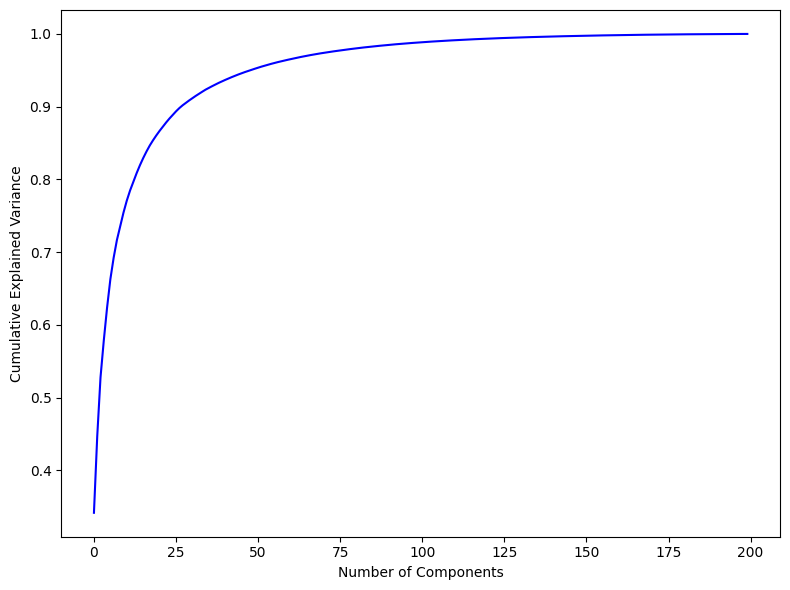

In [33]:
pca = PCA(n_components=200)
pca.fit(X_train)

plt.figure(figsize=(8,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.tight_layout()
plt.show()

#### 2. **Cross-Validation**:

**Cross-validation** can be used to evaluate model performance across different numbers of principal components. By testing the model with various component counts and validating the results on different subsets of the data, it helps in identifying the number of components that generalize well.

This approach reduces the risk of **overfitting** to specific characteristics of the training data and ensures that the dimensionality reduction does not negatively affect the model’s predictive performance.

> ✅ *Cross-validation is particularly useful when PCA is used as a preprocessing step before applying supervised learning algorithms.*


In [42]:
components_range = range(1, 201)
cv_scores = []

lda_model = LinearDiscriminantAnalysis()

for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    scores = cross_val_score(lda_model, X_train_pca, y_train, cv=6);
    cv_scores.append(scores.mean());

best_n_components = components_range[np.argmax(cv_scores)]

C:\Users\PCROOM\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\PCROOM\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\PCROOM\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\PCROOM\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\PCROOM\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in 

In [43]:
print(f"The Best dimension for PCA is {best_n_components}")

The Best dimension for PCA is 49


### Result: Optimal Dimensionality in PCA and LDA

In this problem, as observed from the results, the optimal dimensionality reduction using **PCA** occurs approximately between **40 and 50 components**, where a high performance level is achieved.

For the custom-designed **LDA function**, it is also evident that the best accuracy falls within this same dimensionality range. Increasing the number of components beyond this range does not significantly improve the results.

Similarly, when using Python’s built-in **LDA function**, the best accuracy is achieved around **50 dimensions**. However, when the number of dimensions is further increased (e.g., up to **180**), the performance actually **decreases**, indicating that excessive dimensionality can harm the model's effectiveness.
